In [13]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor, DistanceMetric
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.metrics import r2_score
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN
from ml_utils import graph
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from nca import NCA
import collections
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go 

init_notebook_mode(connected=True)

%pylab inline
pylab.rcParams['figure.figsize'] = (15,9)

out_dir = '~/ftb/papi_output/speedup/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['plot', 'clf']
`%matplotlib` prevents importing * from pylab and numpy



In [3]:
def aggregate(df):
    return df.groupby(['alg','run'])[df.columns[2:]].min()

def remove_outliers(x, y, df):
    xs = RobustScaler().fit_transform(x)
    
    db = DBSCAN(eps=1.9, min_samples=5, metric='chebyshev')
    cluster_labels = db.fit_predict(xs)
    x2 = [xi for cl, xi in zip(cluster_labels, x) if cl != -1]
    y2 = [yi for cl, yi in zip(cluster_labels, y) if cl != -1]
    df = df.drop(df.index[[i for i, cl in enumerate(cluster_labels) if cl == -1]])
    print('\t', len(x)-len(x2), 'outliers removed')
    return np.array(x2), np.array(y2), df

In [221]:
def best_neigh(x, y, df, pca_range, neigh_range):
    best = -inf
    best_n = (None, None)
    best_clf = (None, None)

    for n_comp in pca_range:
        for n_neigh in neigh_range:
            pca = PCA(n_components=n_comp)
            pca.fit(x)
            x2 = pca.transform(x)
            x2_test = x2
            y2_test = y
            #x2, y2, df2 = remove_outliers(x2, y, df)
            y2=y
            
            neigh = KNeighborsRegressor(n_neighbors=n_neigh, weights='distance')
            neigh.fit(x2, y2)
            
            groups = list(df.index.get_level_values(0))
            
            cv=GroupKFold(n_splits=3).split(x2_test, y2_test, groups)
            score = cross_val_score(neigh, x2_test, y2_test, cv=cv).mean()
            print(n_comp, '\t', n_neigh, '\t', round(score, 2))
            
            if score > best:
                best = score
                best_n = (n_comp, n_neigh)
                best_clf = (pca, neigh)
                
    print('--------------')
    print('PCA:\t', best_n[0])
    print('kNN:\t', best_n[1])
    print('Score:\t', best)
    return best_clf, x2

In [263]:
def load_data(files, scaler=None):
    paths = [out_dir + p for p in files]

    dfs_O0 = [pd.read_csv(path + '_O0.csv', error_bad_lines=False) for path in paths]
    df_O0 = pd.concat(dfs_O0)
    df_O0['run'] = df_O0['run'].astype(str)  
    df_O0 = aggregate(df_O0)
    print(df_O0.shape)
    
    dfs_O3 = [pd.read_csv(path + '_O3.csv', error_bad_lines=False) for path in paths]
    df_O3 = pd.concat(dfs_O3)
    df_O3['run'] = df_O3['run'].astype(str)
    df_O3 = df_O3[['alg', 'run', 'time_O3']]
    df_O3 = aggregate(df_O3)
    print(df_O3.shape)
    
    df_meta = pd.read_csv('/home/maciej/ftb/kernels_lore/proc/metadata.csv', index_col='alg')
    
    df = df_O0.merge(df_O3, left_index=True, right_index=True)
    df['max_dim'] = df.index.get_level_values(0)
    df['max_dim'] = df['max_dim'].apply(lambda q: df_meta.loc[q]['max_dim'])
    df = df.loc[df['time_O3'] > 0]
    #df = df.loc[df['max_dim'] == 2]
    
    for col in df.columns:
        if col[:4] == 'PAPI' and col != 'PAPI_TOT_INS':
            df[col] = df[col].astype(float).div(df['PAPI_TOT_INS'], axis=0)
    df['PAPI_TOT_INS'] = 1
    df = df.dropna()  
    
    df['speedup'] = df['time_O0'] / df['time_O3']

    cols = sorted(list(df.columns.values))
    df = df[cols]

    x = df.drop(['time_O0', 'time_O3', 'speedup', 'max_dim'],axis=1).values
    y = df['speedup'].values
    
    if scaler is None:
        scaler = RobustScaler(quantile_range=(10,90))
        #scaler = StandardScaler()
        x = scaler.fit_transform(x)
    else:
        x = scaler.transform(x)

    print(df.shape)
    
    return x, y, df, scaler

In [269]:
x, y, df, scaler = load_data(['o1', 'o2', 'o3', 'o4'])

(7446, 53)
(7441, 1)
(1351, 56)


In [7]:
(pca, neigh), x2 = best_neigh(x, y, df, range(2, 15, 2), range(6, 20, 5))
clf = neigh

2 	 6 	 0.19
2 	 11 	 0.26
2 	 16 	 0.3
4 	 6 	 0.33
4 	 11 	 0.4
4 	 16 	 0.41
6 	 6 	 0.35
6 	 11 	 0.38
6 	 16 	 0.37
8 	 6 	 0.41
8 	 11 	 0.42
8 	 16 	 0.44
10 	 6 	 0.57
10 	 11 	 0.56
10 	 16 	 0.53
12 	 6 	 0.57
12 	 11 	 0.56
12 	 16 	 0.53
14 	 6 	 0.58
14 	 11 	 0.57
14 	 16 	 0.54
--------------
PCA:	 14
kNN:	 6
Score:	 0.5781715569229896


In [265]:
pca = PCA(n_components=14)
pca.fit(x)
x2 = pca.transform(x)

x_test = x2
y_test = y
df_test = df

#x2, y, df = remove_outliers(x2, y, df)
pca.explained_variance_ratio_.sum()

0.9999240214084744

In [229]:
nca = NCA(dim=6, optimizer='gd')
x2 = nca.fit_transform(x2, y)

x_test = x2
y_test = y
df_test = df
#print(nca.A)

   0 -692.570595
   1 -695.806371
   2 -701.257969
   3 -710.925759
   4 -727.099641
   5 -749.013056
   6 -769.064296
   7 -781.414680
   8 -788.397722
   9 -792.823749
  10 -795.793111
  11 -797.941863
  12 -799.607359
  13 -800.961084
  14 -802.100819
  15 -803.087117
  16 -803.959827
  17 -804.746466
  18 -805.466826
  19 -806.135668
  20 -806.764381
  21 -807.362051
  22 -807.936162
  23 -808.493096
  24 -809.038474
  25 -809.577423
  26 -810.114784
  27 -810.655278
  28 -811.203657
  29 -811.764843
  30 -812.344056
  31 -812.946941
  32 -813.579702
  33 -814.249234
  34 -814.963250
  35 -815.730383
  36 -816.560144
  37 -817.462578
  38 -818.447370
  39 -819.522467
  40 -820.692857
  41 -821.959409
  42 -823.315778
  43 -824.755683
  44 -826.296501
  45 -827.979210
  46 -829.862556
  47 -832.013351
  48 -834.459051
  49 -837.107437
  50 -839.801169
  51 -842.497699
  52 -845.252517
  53 -848.127425
  54 -851.164206
  55 -854.382747
  56 -857.781110
  57 -861.337357
  58 -865.0138

 462 -1176.263034
 463 -1176.370055
 464 -1176.476583
 465 -1176.582623
 466 -1176.688177
 467 -1176.793250
 468 -1176.897845
 469 -1177.001966
 470 -1177.105617
 471 -1177.208800
 472 -1177.311520
 473 -1177.413781
 474 -1177.515586
 475 -1177.616938
 476 -1177.717842
 477 -1177.818300
 478 -1177.918317
 479 -1178.017895
 480 -1178.117039
 481 -1178.215752
 482 -1178.314037
 483 -1178.411898
 484 -1178.509339
 485 -1178.606362
 486 -1178.702972
 487 -1178.799171
 488 -1178.894963
 489 -1178.990352
 490 -1179.085340
 491 -1179.179932
 492 -1179.274130
 493 -1179.367938
 494 -1179.461359
 495 -1179.554397
 496 -1179.647054
 497 -1179.739335
 498 -1179.831242
 499 -1179.922778
 500 -1180.013947
 501 -1180.104752
 502 -1180.195196
 503 -1180.285283
 504 -1180.375016
 505 -1180.464397
 506 -1180.553430
 507 -1180.642118
 508 -1180.730464
 509 -1180.818471
 510 -1180.906143
 511 -1180.993482
 512 -1181.080491
 513 -1181.167174
 514 -1181.253533
 515 -1181.339572
 516 -1181.425293
 517 -1181

 918 -1205.304279
 919 -1205.358174
 920 -1205.419472
 921 -1205.495863
 922 -1205.605401
 923 -1205.781113
 924 -1206.002804
 925 -1206.135609
 926 -1206.204118
 927 -1206.257988
 928 -1206.307280
 929 -1206.354425
 930 -1206.400284
 931 -1206.445258
 932 -1206.489563
 933 -1206.533332
 934 -1206.576653
 935 -1206.619586
 936 -1206.662176
 937 -1206.704456
 938 -1206.746455
 939 -1206.788193
 940 -1206.829689
 941 -1206.870960
 942 -1206.912018
 943 -1206.952875
 944 -1206.993543
 945 -1207.034030
 946 -1207.074345
 947 -1207.114495
 948 -1207.154486
 949 -1207.194326
 950 -1207.234018
 951 -1207.273569
 952 -1207.312982
 953 -1207.352261
 954 -1207.391410
 955 -1207.430432
 956 -1207.469330
 957 -1207.508106
 958 -1207.546762
 959 -1207.585300
 960 -1207.623723
 961 -1207.662031
 962 -1207.700226
 963 -1207.738310
 964 -1207.776285
 965 -1207.814151
 966 -1207.851911
 967 -1207.889565
 968 -1207.927116
 969 -1207.964567
 970 -1208.001918
 971 -1208.039172
 972 -1208.076331
 973 -1208

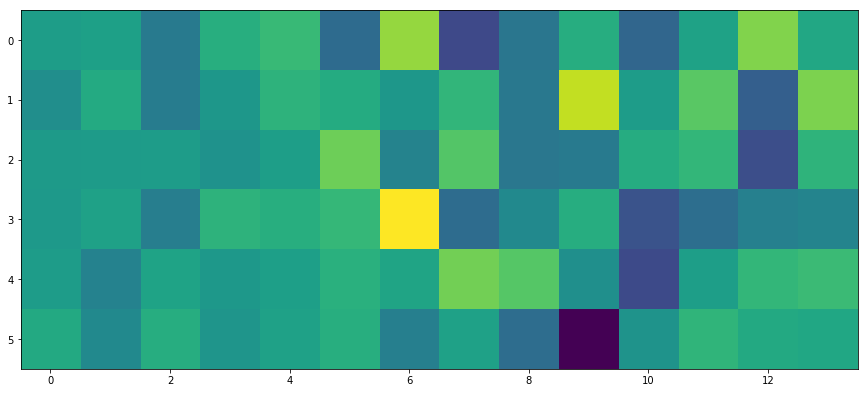

In [240]:
plt.imshow(nca.A)

In [238]:
neigh = KNeighborsRegressor(n_neighbors=3, weights='distance')
neigh.fit(x2, y) 
clf = neigh

In [293]:
groups = list(df_test.index.get_level_values(0))

cv=GroupKFold(n_splits=3).split(x_test, y_test, groups)
cvres = list(cv)
group_names = [groups[q[1][0]] for q in cvres]

scores = cross_val_score(clf, x_test, y_test, cv=cvres)

scores.mean()

0.4740313556241123

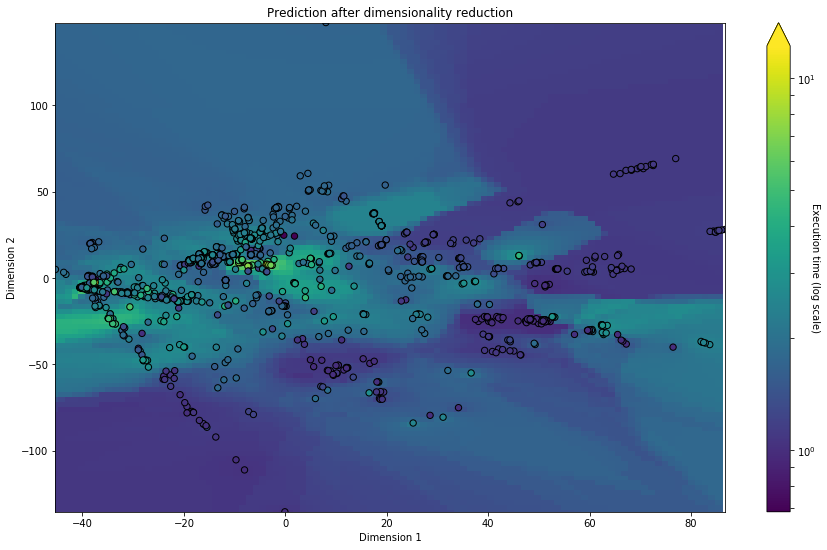

In [37]:
groups = list(df.index.get_level_values(0))
labels = [q.split('_')[-2][-2:] + q.split('_')[-1] for q in groups]
graph(clf, x2, y)
#graph(clf, x2, y, xlim=(-7.7,-4),ylim=(-3,-1), labels=labels)

In [38]:
labels = [q[-6:] for q in groups]

trace1 = go.Scatter(x=x2[:,0], y=x2[:,1], mode='markers', text=labels, hoverinfo='text',
                        marker = dict(size=8, color=[np.log(q) for q in y], line=dict(width=1, color='rgb(0, 0, 0)')))

layout = go.Layout(showlegend=False, hovermode='closest',
               yaxis=dict(zeroline=False, title='dim2'),
               xaxis=dict(zeroline=False, title='dim1'))

fig = go.Figure(data = [trace1], layout = layout)
iplot(fig, filename="c-v-predict")

In [39]:
trace1 = go.Scatter3d(x=x2[:,0], y=x2[:,1], z=x2[:,2], mode='markers', hoverinfo='none',
                        marker = dict(size=2, color=[np.log(q) for q in y], line=dict(width=1, color='rgb(0, 0, 0)')))

layout = go.Layout(showlegend=False,
               yaxis=dict(zeroline=False, title='dim2', ticks='', showticklabels=False),
               xaxis=dict(zeroline=False, title='dim1', ticks='', showticklabels=False))

fig = go.Figure(data = [trace1], layout = layout)
iplot(fig, filename="c-v-predict")

IndexError: index 2 is out of bounds for axis 1 with size 2

In [9]:
model_path = '../lore/models/'
joblib.dump(scaler, model_path + 'scaler.pkl') 
joblib.dump(pca, model_path + 'pca.pkl')
joblib.dump(neigh, model_path + 'neigh.pkl') 

['../lore/models/neigh.pkl']

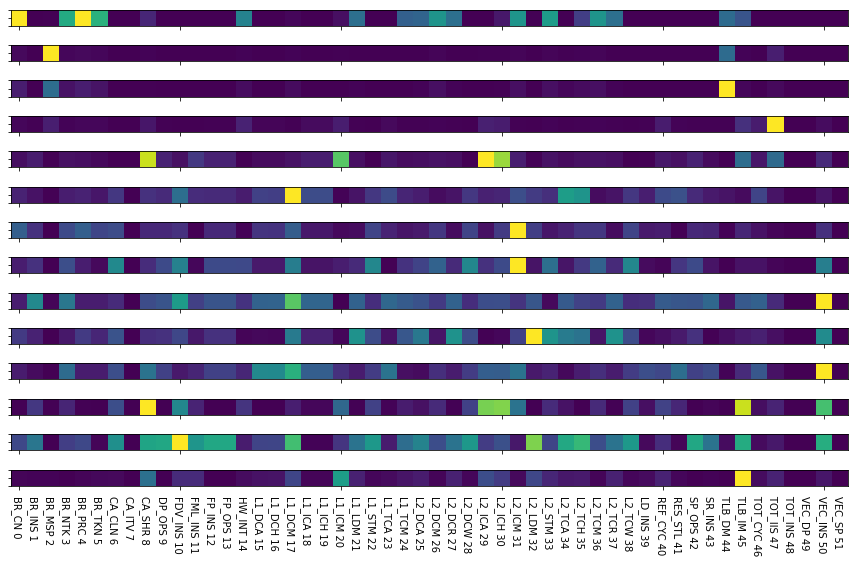

In [254]:
lab = df.columns[:52]

fig, axs = plt.subplots(nrows=pca.n_components)
for i, ax in enumerate(axs): 
    if i == pca.n_components - 1:
        for j, txt in enumerate(lab):
            ax.annotate('        '+txt[5:]+' '+str(j), (j-.5, 0), rotation=270)
    pcas = [abs(q) for q in pca.components_[i:i+1]]
    ax.imshow(pcas)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.show()

In [275]:
def best_pair_feat(x2, y, df):
    dim = x2.shape[1]
    pairs = [(f1, f2, f3) for f1 in range(dim) 
             for f2 in range(dim) 
             for f3 in range(dim) 
             if f1 < f2 and f2 < f3 ]
    best = 0
    
    for p in pairs:
        x3 = x2[:,p]
        
        neigh = KNeighborsRegressor(n_neighbors=6, weights='distance')
        neigh.fit(x3, y) 
        
        groups = list(df.index.get_level_values(0))
        cv=GroupKFold(n_splits=3).split(x3, y, groups)
        score = cross_val_score(neigh, x3, y, cv=cv).mean()
        if score > best:
            print(p, '\t', round(score, 2))
            best = score

In [283]:
def best_features(x2, y, df):
    dim = x2.shape[1]
    feats = set()
    others = set(range(dim))
    
    best = float('-infinity')
    
    while True:
        best_feat = None
        
        for f in others:
            curr_feats = feats.copy()
            curr_feats.add(f)
            x3 = x2[:,list(curr_feats)]

            neigh = KNeighborsRegressor(n_neighbors=6, weights='distance')
            neigh.fit(x3, y) 

            groups = list(df.index.get_level_values(0))
            cv=GroupKFold(n_splits=3).split(x3, y, groups)
            score = cross_val_score(neigh, x3, y, cv=cv).mean()
            if score > best:
                print(feats, f, '\t', round(score, 2))
                best = score
                best_feat = f
                
        if best_feat is None:
            return feats
        else:
            feats.add(best_feat)
            others.remove(best_feat)

In [352]:
best_features(x, y, df)

set() 0 	 -0.36
set() 1 	 -0.12
set() 6 	 -0.05
set() 9 	 -0.05
set() 24 	 0.03
set() 33 	 0.03
{33} 1 	 0.1
{33} 3 	 0.19
{33, 3} 6 	 0.27
{33, 3} 21 	 0.27
{33, 3} 25 	 0.3
{33, 3, 25} 0 	 0.33
{33, 3, 25} 1 	 0.4
{33, 3, 25} 8 	 0.4
{33, 3, 25} 14 	 0.53
{33, 3, 25, 14} 6 	 0.53
{33, 3, 25, 14} 10 	 0.55
{33, 3, 10, 14, 25} 6 	 0.56
{33, 3, 10, 14, 25} 21 	 0.56
{33, 3, 10, 14, 25} 37 	 0.56
{33, 3, 37, 10, 14, 25} 6 	 0.57
{33, 3, 37, 10, 14, 25} 50 	 0.57
{33, 3, 37, 10, 14, 50, 25} 6 	 0.58


{3, 6, 10, 14, 25, 33, 37, 50}

In [276]:
best_pair_feat(x, y, df)

(0, 1, 14) 	 0.07
(0, 1, 21) 	 0.25
(0, 1, 37) 	 0.25
(0, 3, 21) 	 0.28
(0, 3, 37) 	 0.28
(0, 9, 35) 	 0.35
(5, 9, 35) 	 0.36
(5, 25, 45) 	 0.36
(9, 21, 43) 	 0.38
(9, 37, 43) 	 0.39


In [344]:
def dim_sign(df, x, y):
    regr = RandomForestRegressor()
    regr.fit(x, y)
    res = [(i, col, imp) for i, (col, imp) in enumerate(zip(df.columns, regr.feature_importances_))]
    res = sorted(res, key=lambda q: q[2], reverse=True)

    #for i, c, imp in res:
    #    print(i, '\t', c, '\t', round(imp*100, 2), '%')
    
    return np.array(res)

In [351]:
feats = set()
best = float('-infinity')

for i, _, _ in dim_sign(df, x, y):
    curr_feats = feats.copy()
    curr_feats.add(int(i))
    
    x3 = x[:,list(curr_feats)]

    neigh = KNeighborsRegressor(n_neighbors=6, weights='distance')
    neigh.fit(x3, y) 

    groups = list(df.index.get_level_values(0))
    cv=GroupKFold(n_splits=3).split(x3, y, groups)
    score = cross_val_score(neigh, x3, y, cv=cv).mean()
    
    if score > best:
        best = score
        feats.add(int(i))
        print(i, '\t', round(score, 2))

14 	 -0.23
33 	 -0.08
3 	 0.11
32 	 0.3
39 	 0.37
9 	 0.43
4 	 0.45
6 	 0.45
26 	 0.45
43 	 0.47
0 	 0.47
10 	 0.5
50 	 0.53


In [350]:
q = dim_sign(df, x, y)
curr_feats = np.random.choice(q[:, 0].astype('int'), size=3, p=q[:, 2].astype('float64'))

x3 = x[:, curr_feats]

neigh = KNeighborsRegressor(n_neighbors=6, weights='distance')
neigh.fit(x3, y) 

groups = list(df.index.get_level_values(0))
cv=GroupKFold(n_splits=3).split(x3, y, groups)
score = cross_val_score(neigh, x3, y, cv=cv).mean()

if score > best:
    best = score
    feats.add(i)
    print(i, '\t', round(score, 2))

In [345]:
dim_sign(df, x, y)

array([['14', 'PAPI_HW_INT', '0.1723314688128888'],
       ['39', 'PAPI_LD_INS', '0.08413142033038792'],
       ['36', 'PAPI_L2_TCM', '0.06974692412467114'],
       ['32', 'PAPI_L2_LDM', '0.06781250689144279'],
       ['3', 'PAPI_BR_NTK', '0.05963626639958134'],
       ['33', 'PAPI_L2_STM', '0.05948241443805176'],
       ['2', 'PAPI_BR_MSP', '0.05670095763896018'],
       ['44', 'PAPI_TLB_DM', '0.040200417944144536'],
       ['26', 'PAPI_L2_DCM', '0.031211175893947996'],
       ['24', 'PAPI_L1_TCM', '0.02535421119178638'],
       ['45', 'PAPI_TLB_IM', '0.023950369509406173'],
       ['12', 'PAPI_FP_INS', '0.018378813643193406'],
       ['47', 'PAPI_TOT_IIS', '0.01765075071025368'],
       ['5', 'PAPI_BR_TKN', '0.017452086193648672'],
       ['6', 'PAPI_CA_CLN', '0.0167897831446071'],
       ['8', 'PAPI_CA_SHR', '0.01653393403103087'],
       ['20', 'PAPI_L1_ICM', '0.015420006670583169'],
       ['43', 'PAPI_SR_INS', '0.014690145559496753'],
       ['11', 'PAPI_FML_INS', '0.014582872073